## Problema 1: Optimización Multiobjetivo en Distribución de Recursos para Misión Humanitaria

## Problema 2: Optimización Multiobjetivo en Planificación de Rutas de Inspección

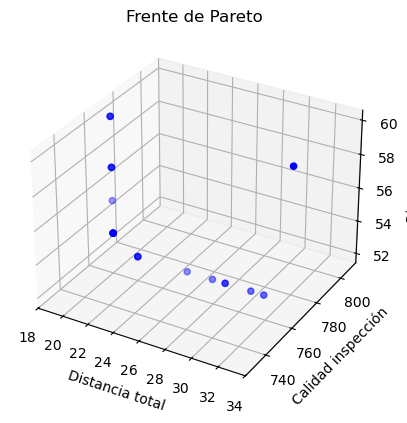

In [ ]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory

# === Función para leer la matriz de costos (distancias) desde CSV ===
def read_cost_matrix_csv(filename):
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        node_ids = next(reader)
        data = list(reader)
    cost_matrix = np.array(data, dtype=int)
    return cost_matrix

# === Leer datos ===
cost_matrix = read_cost_matrix_csv('cost_matrix_10_nodes_1.5_spread.csv')
num_nodes = len(cost_matrix)
nodes = range(num_nodes)
vehicles = range(3)

# === Calidad por nodo (excepto nodo 0) ===
calidad_inspeccion = {
    1: 85, 2: 92, 3: 78, 4: 90, 5: 82,
    6: 88, 7: 95, 8: 75, 9: 84
}
cota_calidad = 100
cota_calidad_total = sum(cota_calidad for _ in calidad_inspeccion)

# === Riesgo por arco ===
riesgo_datos = {
    (0, 1): 3, (0, 2): 2, (0, 3): 4, (0, 4): 5,
    (0, 5): 6, (0, 6): 3, (0, 7): 2, (0, 8): 4, (0, 9): 5,
    (2, 8): 9, (2, 9): 8, (3, 4): 5, (4, 9): 7,
    (5, 6): 7, (8, 9): 7
}
riesgo_arcos = {(i, j): riesgo_datos.get((i, j), 5) for i in nodes for j in nodes if i != j}

# === Resultados ===
z1_vec, z2_vec, z3_vec = [], [], []

# === Pesos ===
num_iter = 7
w_vals = np.linspace(0, 1, num_iter)
peso_combinaciones = [(w1, w2, 1 - w1 - w2)
                      for w1 in w_vals for w2 in w_vals if w1 + w2 <= 1]

for w1, w2, w3 in peso_combinaciones:
    model = ConcreteModel()
    model.N = Set(initialize=nodes)
    model.K = Set(initialize=vehicles)
    model.x = Var(model.N, model.N, model.K, domain=Binary)
    model.u = Var(model.N, model.K, domain=NonNegativeIntegers, bounds=(1, num_nodes - 1))

    #funciones objetivo
    z1 = sum(model.x[i, j, k] * cost_matrix[i][j]
             for i in model.N for j in model.N if i != j for k in model.K)

    z2_real = sum(calidad_inspeccion.get(j, 0) *
                  sum(model.x[i, j, k] for i in model.N if i != j for k in model.K)
                  for j in model.N if j != 0)
    z2 = cota_calidad_total - z2_real  # no calidad 

    z3 = sum(model.x[i, j, k] * riesgo_arcos[i, j]
             for i in model.N for j in model.N if i != j for k in model.K)

    model.z1 = z1
    model.z2 = z2
    model.z3 = z3

    # Función objetivo sin normalizar
    model.Obj = Objective(expr=w1 * model.z1 + w2 * model.z2 + w3 * model.z3, sense=minimize)

    # restricciones 
    def visit_once(model, j):
        if j != 0:
            return sum(model.x[i, j, k] for i in model.N if i != j for k in model.K) == 1
        return Constraint.Skip
    model.visit_once = Constraint(model.N, rule=visit_once)

    def salida_deposito(model, k):
        return sum(model.x[0, j, k] for j in model.N if j != 0) == 1
    model.salida = Constraint(model.K, rule=salida_deposito)

    def entrada_deposito(model, k):
        return sum(model.x[i, 0, k] for i in model.N if i != 0) == 1
    model.entrada = Constraint(model.K, rule=entrada_deposito)
    
    # Conservación del flujo
    def conservacion_flujo(model, i, k):
        if i != 0:  # Excluir el nodo 0 de la conservación de flujo
            return sum(model.x[i, j, k] for j in model.N if j != i) - sum(model.x[j, i, k] for j in model.N if j != i) == 0
        return Constraint.Skip
    model.conservacion_flujo = Constraint(model.N, model.K, rule=conservacion_flujo)

    def mtz_rule(model, i, j, k):
        if i != 0 and j != 0 and i != j:
            return model.u[i, k] - model.u[j, k] + num_nodes * model.x[i, j, k] <= num_nodes - 1
        return Constraint.Skip
    model.subtour_elim = Constraint(model.N, model.N, model.K, rule=mtz_rule)
    

    SolverFactory('glpk').solve(model)

    z1_vec.append(value(z1))
    z2_vec.append(value(z2_real)) 
    z3_vec.append(value(z3))
# === Visualización ===
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z1_vec, z2_vec, z3_vec, c='blue', marker='o')
ax.set_xlabel('Distancia total')
ax.set_ylabel('Calidad inspección')
ax.set_zlabel('Riesgo total')
plt.title('Frente de Pareto')
plt.grid(True)
plt.show()
